# 1. Loading im.db as pd.df

In [5]:
import pandas as pd
import sqlite3

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline


In [6]:
conn = sqlite3.connect('data/im.db')
cursor = conn.cursor()

In [7]:
imdb_basics = pd.read_sql('''
SELECT *
FROM movie_basics
''', conn)

imdb_akas = pd.read_sql('''
SELECT *
FROM movie_akas
WHERE region = 'US'
GROUP BY movie_id
''', conn)

imdb_ratings = pd.read_sql('''
SELECT *
FROM movie_ratings
''', conn)

# 2. Name of df Variables:

### imdb Variables (each variable is an individual table):
- imdb_basics
- imdb_akas
- imdb_ratings

# 3. Merging IMDB

In [8]:
akas_basics_merge = imdb_akas.merge(imdb_basics, on='movie_id',
                                        how='inner')
imdb_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [9]:
imdb_merged = akas_basics_merge.merge(imdb_ratings, on='movie_id',
                                       how='left')
imdb_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47433 entries, 0 to 47432
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           47433 non-null  object 
 1   ordering           47433 non-null  int64  
 2   title              47433 non-null  object 
 3   region             47433 non-null  object 
 4   language           325 non-null    object 
 5   types              4977 non-null   object 
 6   attributes         1652 non-null   object 
 7   is_original_title  47428 non-null  float64
 8   primary_title      47433 non-null  object 
 9   original_title     47432 non-null  object 
 10  start_year         47433 non-null  int64  
 11  runtime_minutes    39673 non-null  float64
 12  genres             46840 non-null  object 
 13  averagerating      26654 non-null  float64
 14  numvotes           26654 non-null  float64
dtypes: float64(4), int64(2), object(9)
memory usage: 5.8+ MB


# 4. Cleaning tn.movie_budgets for merge

In [10]:
tn_budgets = pd.read_csv('data/tn.movie_budgets.csv.gz')

In [11]:
tn_budgets.drop_duplicates(subset = ['movie'], inplace=True)

In [12]:
tn_budgets.rename(columns = {'movie':'primary_title'}, inplace=True)

In [13]:
#Creating new coumn called year that is date.time
tn_budgets['Release_Date_Time'] = pd.to_datetime(tn_budgets['release_date'])
tn_budgets['start_year'] = tn_budgets['Release_Date_Time'].dt.year

# 5: MERGE Merging Budgets to IMDB

#### Also changing columns to match Anat and Keanan

In [14]:
full_movies_df = imdb_merged.merge(tn_budgets, on= ['primary_title','start_year'], how= 'inner')

In [15]:
full_movies_df['Release_Date_Time'] = pd.to_datetime(full_movies_df['release_date'])
full_movies_df['month'] = full_movies_df['Release_Date_Time'].dt.month

In [16]:
full_movies_df['worldwide_gross'] = full_movies_df['worldwide_gross'].str.replace('$','').str.replace(',','').astype(float)
full_movies_df['production_budget'] = full_movies_df['production_budget'].str.replace('$','').str.replace(',','').astype(float)
full_movies_df['domestic_gross'] = full_movies_df['domestic_gross'].str.replace('$','').str.replace(',','').astype(float)

# Analysis:
# Trends in Genre

In [209]:
#converting dataset to SQL to filter/drop columns easily
full_movies_sql = full_movies_df.to_sql('genres', conn, if_exists='replace', index = False)

In [231]:
#Using tables that are unique and useful
full_movies = pd.read_sql('''
SELECT movie_id, primary_title, genres, start_year, runtime_minutes,
        averagerating, numvotes, production_budget, worldwide_gross
FROM genres 
''', conn)

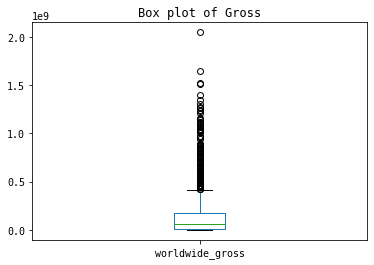

In [232]:
#boxplot of 'worldwide_gross' to find the best measure of central tendency
full_movies["worldwide_gross"].plot(kind="box", title="Box plot of Gross")
plt.show()

In [205]:
# spliting the genres column up so that each movie has an entry for each genre listed

genres = (genre_no_out.genres.str.split(',', expand=True)
            .stack()
            .to_frame(name='genres'))

genres.index = genres.index.droplevel(1)


In [228]:
# creating a new df by merging new columns back on the data set grouped by the median based off of box plot
genre_gross = (genres.join(genre_no_out.loc[:,['worldwide_gross']]).groupby('genres').median().sort_values('worldwide_gross', ascending=False))

In [229]:
#adding an index to new df because I don't know how to graph using the index as the x-axis
genre_gross_df = genre_gross.reset_index()

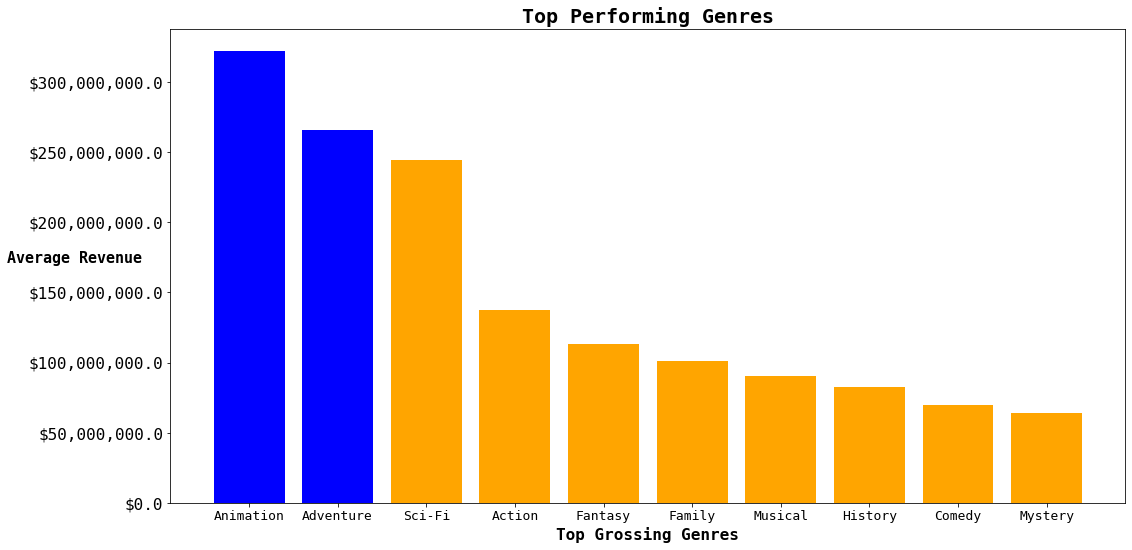

In [218]:
#my beautiful Graph 

plt.rcParams['font.family'] = 'monospace'

x = genre_gross_df['genres'].head(10)
height= genre_gross_df['worldwide_gross'].head(10)
fig, ax = plt.subplots(figsize=(16,8))


color=['blue', 'blue', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']
ax.bar(x=x, height=height, color=color)


plt.title("Top Performing Genres", fontsize=20, loc='center', weight='bold')
ax.set_xlabel('Top Grossing Genres', fontsize=16, weight='bold')

ax.set_ylabel('Average Revenue', fontsize=15, rotation=360, weight='bold', loc='center')
ax.ticklabel_format(style='plain', axis='y')

ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', labelsize=13)

ax.yaxis.set_label_coords(-0.1, 0.5)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))

plt.tight_layout(pad = 2.0)
plt.savefig('top_genres.jpg', dpi=400)














# Reccomendation Based on Our Combined Insights

In [ ]:
full_movies_sql = full_movies_df.to_sql('genres', conn, if_exists='replace', index = False)

In [ ]:
#### I can't get the month column to work correctly in the query. Not sure why

In [136]:
recomendation = pd.read_sql('''
SELECT title, movie_id, production_budget, worldwide_gross, month, genres
FROM genres
WHERE production_budget >= 65000000
                AND genres LIKE '%Adventure,Animation%'
ORDER BY worldwide_gross desc
''', conn)

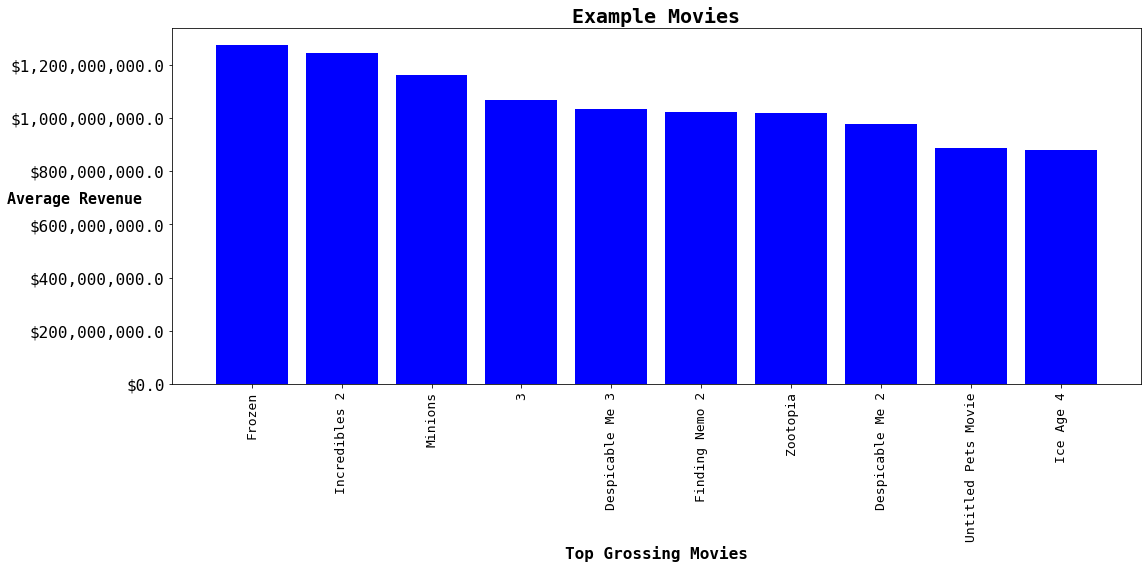

In [148]:
plt.rcParams['font.family'] = 'monospace'

x = recomendation['title'].head(10)
height= recomendation['worldwide_gross'].head(10)
fig, ax = plt.subplots(figsize=(16,8))



ax.bar(x=x, height=height, color= 'blue')


plt.title("Example Movies", fontsize=20, loc='center', weight='bold')
ax.set_xlabel('Top Grossing Movies', fontsize=16, weight='bold')

ax.set_ylabel('Average Revenue', fontsize=15, rotation=360, weight='bold', loc='center')
ax.ticklabel_format(style='plain', axis='y')

ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', labelsize=13, rotation = 90)

ax.yaxis.set_label_coords(-0.1, 0.5)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))

plt.tight_layout()
plt.savefig('example_reccomendations.jpg', dpi=400)

In [153]:
recomendation.head(10)

,title,movie_id,production_budget,worldwide_gross,month,genres
0,Frozen,tt2294629,150000000.0,1.272470e+09,11,"Adventure,Animation,Comedy"
1,Incredibles 2,tt3606756,200000000.0,1.242521e+09,6,"Action,Adventure,Animation"
2,Minions,tt2293640,74000000.0,1.160336e+09,7,"Adventure,Animation,Comedy"
3,3,tt0435761,200000000.0,1.068880e+09,6,"Adventure,Animation,Comedy"
4,Despicable Me 3,tt3469046,75000000.0,1.034728e+09,6,"Adventure,Animation,Comedy"
5,Finding Nemo 2,tt2277860,200000000.0,1.021215e+09,6,"Adventure,Animation,Comedy"
6,Zootopia,tt2948356,150000000.0,1.019430e+09,3,"Adventure,Animation,Comedy"
7,Despicable Me 2,tt1690953,76000000.0,9.752168e+08,7,"Adventure,Animation,Comedy"
8,Untitled Pets Movie,tt2709768,75000000.0,8.867505e+08,7,"Adventure,Animation,Comedy"
9,Ice Age 4,tt1667889,95000000.0,8.797651e+08,7,"Adventure,Animation,Comedy"
